In [1]:
%matplotlib inline
from pycocotools.coco import COCO
import os
import numpy as np
import random
import skimage.io as io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pylab
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets
from tensorflow.contrib.layers.python.layers import utils

import resnet_v2 as resnet
# import cv2
pylab.rcParams['figure.figsize'] = (10.0, 8.0)


# Initialize Dataset

In [2]:
def get_data(base_dir,image_dir,ann_file):
    image_path = '{}/images/{}'.format(baseDir,image_dir)
    ann_path='{}/annotations/{}.json'.format(baseDir,ann_file)

    return image_path, ann_path
    
# define the path to the annotation file corresponding to the images you want to work with
baseDir='/Users/kyle/Repositories/coco'

trainData='person_keypoints_train2014'
valData='person_keypoints_val2014'
testData='image_info_test-dev2015'

imageTrainDir = 'train2014'
imageValDir = 'val2014'
imageTestDir = 'test2015'

train_img_path, train_ann_path = get_data(baseDir,imageTrainDir,trainData)
val_img_path, val_ann_path = get_data(baseDir,imageValDir,valData)
# initialize a coco object
print("Initializing COCO objects to extract training and validation datasets...\n")
train_coco = COCO(train_ann_path)
val_coco = COCO(val_ann_path)
# get all images containing the 'person' category
train_catIds = train_coco.getCatIds(catNms=['person'])
train_imgIds = train_coco.getImgIds(catIds=train_catIds)
val_catIds = val_coco.getCatIds(catNms=['person'])
val_imgIds = val_coco.getImgIds(catIds=val_catIds)
# Just for dealing with the images on my computer (not necessary when working with the whole dataset)
# if args.small_dataset:
train_catIds = train_catIds[0:30]
train_imgIds = train_imgIds[0:30]
val_catIds = val_catIds[0:30]
val_imgIds = val_imgIds[0:30]


Initializing COCO objects to extract training and validation datasets...

loading annotations into memory...
Done (t=8.18s)
creating index...
index created!
loading annotations into memory...
Done (t=4.10s)
creating index...
index created!


In [3]:
#######################################################
############### VARIOUS HYPER-PARAMETERS ##############
#######################################################

NUM_KEYPOINTS = 17
BATCH_SIZE = 5 #args.batch_size
L = 5.0 # keypoint effective radius
D = 224 # image height and width
d = 56 # evaluation height and width (for mask and keypoint masks)

MASK_THRESHOLD = 0.5 # threshold for on/off prediction (in mask and keypoint masks)
KP_THRESHOLD = 0.5 # threshold for on/off prediction (in mask and keypoint masks)
KP_DISTANCE_THRESHOLD = 5.0 # threshold for determining if a keypoint estimate is accurate
X_INIT = tf.contrib.layers.xavier_initializer_conv2d() # xavier initializer for head architecture
# learning_rate1 = args.learning_rate1
# learning_rate2 = args.learning_rate2

#######################################################
#### VISUALIZATION TOOLS - WEIGHTS AND ACTIVATIONS ####
#######################################################
def highestPrimeFactorization(n):    
    return [(i, n//i) for i in range(1, int(n**0.5) + 1) if n % i == 0][-1] 

def getFilterImage(filters):
    """
    Takes as input a filter bank of size (1, H, W, C, D)
    Returns: a tensor of size (1, sqrt(D)*H, sqrt(D)*H, C)
    (This only really works for the first layer of filtes with an image as input)
    """
    padded_filters = tf.pad(filters,tf.constant([[0,0],[1,0],[1,0],[0,0],[0,0]]),'CONSTANT')
    filter_list = tf.unstack(padded_filters,axis=4)
    H,W = highestPrimeFactorization(len(filter_list))
    weight_strips = [tf.concat(filter_list[8*i:8*(i+1)],axis=1) for i in range(W)]
    weight_image = tf.concat(weight_strips,axis=2)
    return weight_image

def getActivationImage(activations):
    """
    Tiles an activation map into a square grayscale image
    Takes as input an activation map of size (N, H, W, D)
    Returns: a tensor of size (N, sqrt(D)*H, sqrt(D)*H, 1)
    """
    padded_activations = tf.pad(activations,tf.constant([[0,0],[1,0],[1,0],[0,0]]),'CONSTANT')
    expanded_activations = tf.expand_dims(padded_activations,axis=3)
    activations_list = tf.unstack(expanded_activations,axis=4)
    H,W = highestPrimeFactorization(len(activations_list))
    activation_strips = [tf.concat(activations_list[H*i:H*(i+1)],axis=1) for i in range(W)]
    activation_image = tf.concat(activation_strips,axis=2)
    return activation_image

In [4]:
#######################################################
##### PRE-PROCESSING AND DATASET EXTRACTION TOOLS #####
#######################################################
def extract_annotations_train(filename, imgID, coco=train_coco):
    anns = coco.loadAnns(coco.getAnnIds(imgID,catIds=[1],iscrowd=None))
    ann = max([ann for ann in anns], key=lambda item:item['area']) # extract annotation for biggest instance
    bbox = np.array(np.floor(ann['bbox']),dtype=int)
    keypoints = np.reshape(ann['keypoints'],(-1,3))
    mask = coco.annToMask(ann)

    return filename, bbox, keypoints, mask

def extract_annotations_val(filename, imgID, coco=val_coco):
    anns = coco.loadAnns(coco.getAnnIds(imgID,catIds=[1],iscrowd=None))
    ann = max([ann for ann in anns], key=lambda item:item['area']) # extract annotation for biggest instance
    bbox = np.array(np.floor(ann['bbox']),dtype=int)
    keypoints = np.reshape(ann['keypoints'],(-1,3))
    mask = coco.annToMask(ann)

    return filename, bbox, keypoints, mask

def preprocess_image_tf(filename, bbox_tensor, keypoints_tensor, mask, D=D):
    """
    Returns:
    resized_image (N,D,D,3) - cropped, scaled to square image of size D
    resized_mask (N,D,D,1) - cropped, scaled to square mask of size D
    pts (N,2,17) - keypoint coordinates (i,j) scaled to match up with resized_image
    labels (N,1,17) - values corresponding to pts: {0: invalid, 1:occluded, 2:valid}
    """
    image_string = tf.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.cast(image_decoded, tf.float32)

    # subtract mean
    image = tf.subtract(image, tf.reduce_mean(image))

    mask = tf.transpose([mask],[1,2,0])
    bbox_tensor = tf.to_float(bbox_tensor)
    keypoints_tensor = tf.to_float(keypoints_tensor)

    sideLength = tf.reduce_max(bbox_tensor[2:],axis=0)
    centerX = tf.floor(bbox_tensor[0] + tf.divide(bbox_tensor[2],tf.constant(2.0)))
    centerY = tf.floor(bbox_tensor[1] + tf.divide(bbox_tensor[3],tf.constant(2.0)))
    center = tf.stack([centerX,centerY])

    corner1 = tf.to_int32(tf.minimum(tf.maximum(tf.subtract(center, tf.divide(sideLength,tf.constant(2.0))),0),
                        tf.reverse(tf.to_float(tf.shape(image)[:2]),tf.constant([0]))))
    corner2 = tf.to_int32(tf.minimum(tf.maximum(tf.add(center, tf.divide(sideLength,tf.constant(2.0))),0),
                        tf.reverse(tf.to_float(tf.shape(image)[:2]),tf.constant([0]))))
    i_shape = tf.subtract(corner2,corner1)
    ##### Move corner 2 to enforce squareness!! #####
    corner2 = corner1 + tf.reduce_min(i_shape)
    sideLength = tf.to_float(tf.reduce_min(corner2-corner1))

    scale = tf.divide(tf.constant(D,tf.float32), sideLength)
    cropped_image = tf.image.crop_to_bounding_box(image,corner1[1],corner1[0],
                                                tf.subtract(corner2,corner1)[1],tf.subtract(corner2,corner1)[0])
    cropped_mask = tf.image.crop_to_bounding_box(mask,corner1[1],corner1[0],
                                                tf.subtract(corner2,corner1)[1],tf.subtract(corner2,corner1)[0])

    pts, labels = tf.split(keypoints_tensor,[2,1],axis=1)
    pts = tf.subtract(pts,tf.to_float(corner1)) # shift keypoints
    pts = tf.multiply(pts,scale) # scale keypoints

    # set invalid pts to 0
    valid = tf.less(pts,tf.constant(D,tf.float32))
    valid = tf.reduce_min(tf.multiply(tf.to_float(valid), tf.to_float(tf.greater(pts,0))), axis=1, keep_dims=True)
    pts = tf.multiply(pts,valid)
    labels = tf.multiply(labels,valid)
    pts = tf.transpose(pts,[1,0])
    labels = tf.transpose(labels,[1,0])
    labels = tf.to_float(tf.greater_equal(labels, 1.5)) # only use labels whose values are 2 - is this a good idea?

    resized_image = tf.image.resize_images(cropped_image,tf.constant([D,D]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    resized_mask = tf.image.resize_images(cropped_mask,tf.constant([D,D]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    return resized_image, resized_mask, pts, labels

def scaleDownMaskAndKeypoints(image, mask, pts, labels, d=d, D=D):
    mask = tf.image.resize_images(mask,tf.constant([d,d]),tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    pts = tf.multiply(pts,tf.constant(d/D))
    return image, mask, pts, labels

def generate_keypoint_masks(image, mask, keypoints, labels, d=d, D=D, L=L):
    X, Y = tf.meshgrid(tf.linspace(0.0,d,d),tf.linspace(0.0,d,d))
    X = tf.reshape(X,[d,d,1])
    Y = tf.reshape(Y,[d,d,1])
    X_stack = tf.tile(X,tf.constant([1,1,17],dtype=tf.int32))
    Y_stack = tf.tile(Y,tf.constant([1,1,17],dtype=tf.int32))

    pts = tf.reshape(keypoints,[1,2,17])
    ptsX, ptsY = tf.split(pts,[1,1],axis=1)
    d1 = tf.square(tf.subtract(X_stack,ptsX))
    d2 = tf.square(tf.subtract(Y_stack,ptsY))

    pt_masks = tf.multiply(tf.divide(tf.constant(1.0),tf.add(d1,d2)+L),L)
    return image, mask, pt_masks, pts, labels

def generate_one_hot_keypoint_masks(image, mask, keypoints, labels, d=d):
    pts = tf.reshape(keypoints,[1,2,17])
    indices = tf.to_int32(pts)
    kp_mask1 = tf.one_hot(depth=d,indices=indices[:,1,:],axis=0)
    kp_mask2 = tf.one_hot(depth=d,indices=indices[:,0,:],axis=1)
    kp_masks = tf.matmul(tf.transpose(kp_mask1,(2,0,1)),tf.transpose(kp_mask2,(2,0,1)))
    kp_masks = tf.transpose(kp_masks,(1,2,0))
    return image, mask, kp_masks, pts, labels


def softmax_keypoint_masks(kpt_masks, d=d):
    return tf.reshape(tf.nn.softmax(tf.reshape(kpt_masks, [-1,d**2,17]),dim=1),[-1,d,d,17])
def bilinear_filter(channels_in,channels_out):
    f = tf.multiply(tf.constant([0.5, 1.0, 0.5],shape=[3,1]),tf.constant([0.5, 1.0, 0.5],shape=[1,3]))
    f = tf.stack([f for i in range(channels_out)],axis=2)
    f = tf.stack([f for i in range(channels_in)],axis=3)
    return f




# get all images containing the 'person' category
train_catIds = train_coco.getCatIds(catNms=['person'])
train_imgIds = train_coco.getImgIds(catIds=train_catIds)
val_catIds = val_coco.getCatIds(catNms=['person'])
val_imgIds = val_coco.getImgIds(catIds=val_catIds)

# Just for dealing with the images on my computer (not necessary when working with the whole dataset)
# if args.small_dataset == True:
train_catIds = train_catIds[0:30]
train_imgIds = train_imgIds[0:30]
val_catIds = val_catIds[0:30]
val_imgIds = val_imgIds[0:30]

################### TRAIN DATASET ###################
train_filenames = tf.constant(['{}/COCO_train2014_{:0>12}.jpg'.format(train_img_path, imgID) for imgID in train_imgIds])
train_imgID_tensor = tf.constant(train_imgIds)
train_dataset = tf.contrib.data.Dataset.from_tensor_slices((train_filenames, train_imgID_tensor))
train_dataset = train_dataset.map(
    lambda filename, imgID: tf.py_func(extract_annotations_train, [filename, imgID], [filename.dtype, tf.int64, tf.int64, tf.uint8]))
train_dataset = train_dataset.map(preprocess_image_tf)
train_dataset = train_dataset.map(scaleDownMaskAndKeypoints)
train_dataset = train_dataset.map(generate_one_hot_keypoint_masks)
train_dataset = train_dataset.shuffle(buffer_size=10000)
train_dataset = train_dataset.batch(BATCH_SIZE)

#################### VAL DATASET ####################
val_filenames = tf.constant(['{}/COCO_val2014_{:0>12}.jpg'.format(val_img_path, imgID) for imgID in val_imgIds])
val_imgID_tensor = tf.constant(val_imgIds)
val_dataset = tf.contrib.data.Dataset.from_tensor_slices((val_filenames, val_imgID_tensor))
val_dataset = val_dataset.map(
    lambda filename, imgID: tf.py_func(extract_annotations_val,[filename, imgID],[filename.dtype, tf.int64, tf.int64, tf.uint8]))
val_dataset = val_dataset.map(preprocess_image_tf)
val_dataset = val_dataset.map(scaleDownMaskAndKeypoints)
val_dataset = val_dataset.map(generate_one_hot_keypoint_masks)
val_dataset = val_dataset.shuffle(buffer_size=10000)
val_dataset = val_dataset.batch(BATCH_SIZE)

iterator = tf.contrib.data.Iterator.from_structure(train_dataset.output_types, train_dataset.output_shapes)

images, masks, kpt_masks, pts, labels = iterator.get_next()
# images, masks, pts, labels = iterator.get_next()
train_init_op = iterator.make_initializer(train_dataset)
val_init_op = iterator.make_initializer(val_dataset)

print("done")

done


# Calculate Accuracy

In [5]:
def keypointPredictionAccuracy(graph, pred_pts, true_pts, labels, threshold, scope='KeypointPrediction'):
    """
    Accuracy is a boolean: 1 if ||pred_pt-true_pt||^2 < threshold^2, 0 otherwise
    """
    with graph.as_default():
        with tf.variable_scope(scope):
            error = tf.reduce_sum(tf.square(tf.subtract(pred_pts, true_pts)), axis=2)
            accuracy = tf.to_float(tf.less(error,tf.square(threshold))) * tf.to_float(tf.greater_equal(labels,1.5))
            accuracy = tf.reduce_sum(accuracy) / (tf.reduce_sum(tf.to_float(tf.greater_equal(labels,1.5))) + 0.00001)
            return accuracy


TensorShape([Dimension(None), Dimension(1), Dimension(2), Dimension(17)])

In [105]:
sess = tf.InteractiveSession()

In [65]:
true_pts = pts
pred_pts = true_pts + 5.0*tf.random_normal([BATCH_SIZE,1,2,17])
threshold = 0.5

error = tf.reduce_sum(tf.square(tf.subtract(pred_pts, true_pts)), axis=2)
accuracy = tf.to_float(tf.less(error,tf.square(threshold))) * tf.to_float(labels)
accuracy = tf.reduce_sum(accuracy) / (tf.reduce_sum(labels) + 0.00001)


In [77]:
def keypointPredictionAccuracy(pred_pts, true_pts, labels, threshold):
    """
    Accuracy is a boolean: 1 if ||pred_pt-true_pt||^2 < threshold^2, 0 otherwise
    """
    error = tf.reduce_sum(tf.square(tf.subtract(pred_pts, true_pts)), axis=2)
    accuracy = tf.to_float(tf.less(error,tf.square(threshold))) * tf.to_float(labels)
    accuracy = tf.reduce_sum(accuracy) / (tf.reduce_sum(labels) + 0.00001)
    return accuracy

In [ ]:
def KeypointPrediction(graph, pred_masks, d, vote_threshold=0.01):
    """
    Input: Keypoint "Heatmap" Tensor
    Output: Keypoint coordinates in tensor form
    """
    x = tf.reshape(tf.linspace(0.5,d-0.5,d),[1,d,1,1])
    # normalize pred per mask
    pred = tf.divide(pred_masks, tf.reduce_max(pred_masks, axis=[1,2]))
    pred = tf.multiply(pred_masks, tf.to_float(tf.greater_equal(pred_masks, vote_threshold))) 
    pred_i = tf.reduce_sum(tf.multiply(pred, x),axis=[1,2])/tf.reduce_sum(pred,axis=[1,2])
    pred_j = tf.reduce_sum(tf.multiply(pred, tf.transpose(x,(0,2,1,3))),axis=[1,2])/tf.reduce_sum(pred,axis=[1,2])
    pred_pts = tf.stack([pred_j,pred_i],axis=1)
    pred_pts = tf.expand_dims(pred_pts,axis=1)
    return pred_pts

In [115]:
kpt_masks.shape
# tf.reduce_max(kpt_masks,axis=[1,2]).shape
tf.divide(kpt_masks, tf.reduce_max(kpt_masks,axis=[1,2]))

TensorShape([Dimension(None), Dimension(17)])

In [119]:
rands = tf.random_normal([10,10])
rands = tf.nn.softmax(rands)
rands = tf.divide(rands, tf.reduce_max(rands))
rands = tf.multiply(rands, tf.to_float(tf.greater(rands, 0.5)))
rands.eval()

array([[ 0.        ,  0.        ,  0.        ,  0.68423045,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.52603918,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.52842182,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.67638713,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        

# Softmax with all zeros?

In [102]:
sess = tf.InteractiveSession()
sess.run(train_init_op)
I,M,KPM,KP,L = sess.run([images, masks, kpt_masks, pts, labels])

In [20]:
prediction_maps = tf.ones_like(kpt_masks)
# prediction_maps = tf.random_normal(kpt_masks[0].shape)
# prediction_maps = kpt_masks[0]

keypoint_masks = kpt_masks

map_shape = prediction_maps.shape.as_list()
flat_shape = (-1,1,map_shape[1]*map_shape[2],map_shape[3])
pred_flat = tf.reshape(prediction_maps, flat_shape)
masks_flat = tf.reshape(keypoint_masks, flat_shape)
# softmax over dimension 1
losses1 = tf.nn.softmax_cross_entropy_with_logits(labels=masks_flat,logits=pred_flat,dim=0)
losses2 = tf.nn.softmax_cross_entropy_with_logits(labels=masks_flat,logits=pred_flat,dim=1)
losses3 = tf.nn.softmax_cross_entropy_with_logits(labels=masks_flat,logits=pred_flat,dim=2)
labelsA = tf.reshape(labels,[-1,1,17])
labelsB = tf.reshape(labels,[-1,1,1,17])

lossesA = tf.multiply(losses3,labelsA) # set loss to zero for invalid keypoints (labels=0)
lossesB = tf.multiply(losses3,labelsB) # set loss to zero for invalid keypoints (labels=0)

In [81]:
sess.run(train_init_op)
L3, Label, LossA, LossB, I, KPM, P = sess.run([losses3, labels, lossesA, lossesB, images, kpt_masks, pts])

In [88]:
i=4
np.sum(P[i] == 0)/2, np.sum(Label[i] == 0), np.sum(LossA[i] == 0)

(17.0, 17, 17)

In [89]:
ptsT = pts.shape

TensorShape([Dimension(None), Dimension(1), Dimension(2), Dimension(17)])

In [67]:
P[i]

array([[[ 21.31979752,  24.16243744,  19.04568672,  29.98984909,
          15.77665043,  36.38578796,  12.50761414,  39.79695511,
          11.08629513,  42.07106781,   0.        ,   0.        ,
           0.        ,   0.        ,   0.        ,   0.        ,   0.        ],
        [ 16.3451786 ,  13.36040688,  13.64467049,  14.21319866,
          14.21319866,  28.99492455,  28.99492455,  45.34010315,
          47.75634766,  55.00507736,  -0.        ,   0.        ,
           0.        ,  -0.        ,  -0.        ,  -0.        ,  -0.        ]]], dtype=float32)

In [68]:
Label[i]

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.]], dtype=float32)

In [69]:
LossA[i]

array([[ 8.05070305,  8.05070305,  8.05070305,  8.05070305,  8.05070305,
         8.05070305,  8.05070305,  8.05070305,  8.05070305,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]], dtype=float32)

In [59]:
np.mean(LossB[i],axis=0)

array([[ 8.05070305,  8.05070305,  8.05070305,  8.05070305,  8.05070305,
         8.05070305,  8.05070305,  8.05070305,  8.05070305,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ]], dtype=float32)

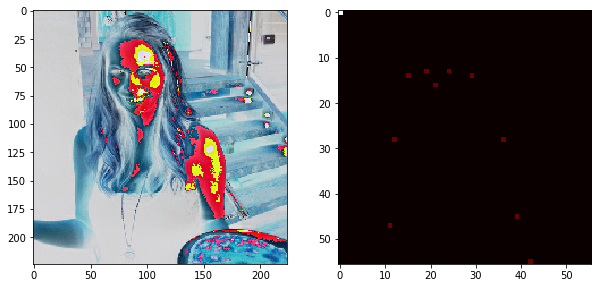

In [48]:
i = 2
plt.subplot(1,2,1)
plt.imshow(I[i])
plt.subplot(1,2,2)
plt.imshow(np.sum(KPM[i],axis=2)*255,cmap="hot")
# plt.subplto(1,3,1)
# plt.imshow(np.sum(LossB[:,:,0,:],axis=2))
# L3[i],LossA[i],LossB[i],P[i]

In [ ]:
logits = tf.random_normal([1,10])
labels = tf.zeros_like(logits)
sft = tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels,dim=0)
sft.eval()

In [ ]:
def softmax_keypoint_masks(kpt_masks, d=56):
    return tf.reshape(tf.nn.softmax(tf.reshape(kpt_masks, [-1,d**2,17]),dim=1),[-1,d,d,17])

# Better visualizations

### 1. Square tiling (rather than prime factorization)

In [ ]:
def highestPrimeFactorization(n):    
    return [(i, n//i) for i in range(1, int(n**0.5) + 1) if n % i == 0][-1] 

In [ ]:
def getFilterImage(filters):
    """
    Takes as input a filter bank of size (1, H, W, C, D)
    Returns: a tensor of size (1, sqrt(D)*H, sqrt(D)*H, C)
    (This only really works for the first layer of filters with an image as input)
    """
    padded_filters = tf.pad(filters,tf.constant([[0,0],[1,0],[1,0],[0,0],[0,0]]),'CONSTANT')
    filter_list = tf.unstack(padded_filters,axis=4)
    N = len(filter_list)
    H = int(np.ceil(np.sqrt(N)))
    W = int(np.floor(N/H))
    diff = N - H*W
    weight_strips = [tf.concat(filter_list[H*i:H*(i+1)],axis=1) for i in range(W)]
    if diff > 0:
        final_strip = tf.concat(filter_list[H*W:N],axis=1)
        final_strip = tf.pad(final_strip,tf.constant([[0,0],[0,(H-diff)*padded_filters.shape.as_list()[1]],[0,0],[0,0]]),'CONSTANT')
        weight_strips.append(final_strip)
    weight_image = tf.concat(weight_strips,axis=2)
    
    return weight_image

In [ ]:
def getActivationImage(activations, scale_up=False):
    """
    Tiles an activation map into a square grayscale image
    Takes as input an activation map of size (N, H, W, D)
    Returns: a tensor of size (N, sqrt(D)*H, sqrt(D)*H, 1)
    """
    padded_activations = tf.pad(activations,tf.constant([[0,0],[1,0],[1,0],[0,0]]),'CONSTANT')
    expanded_activations = tf.expand_dims(padded_activations,axis=3)
    activations_list = tf.unstack(expanded_activations,axis=4)
    N = len(activations_list)
    H = int(np.ceil(np.sqrt(N)))
    W = int(np.floor(N/H))
    diff = N - H*W
    activation_strips = [tf.concat(activations_list[H*i:H*(i+1)],axis=1) for i in range(W)]
    if diff > 0:
        final_strip = tf.concat(activations_list[H*W:N],axis=1)
        final_strip = tf.pad(final_strip,tf.constant([[0,0],[0,(H-diff)*padded_activations.shape.as_list()[1]],[0,0],[0,0]]),'CONSTANT')
        activation_strips.append(final_strip)
    activation_image = tf.concat(activation_strips,axis=2)            
    if scale_up:
        activation_image = tf.divide(activation_image, tf.reduce_max(activation_image))

    return activation_image

In [ ]:
sess = tf.InteractiveSession()

In [ ]:
sess.run(train_init_op)
activations = tf.layers.conv2d(images,64,(3,3),(1,1),padding='SAME')
sess.run(tf.global_variables_initializer())
I, M, KM, P, L = sess.run([images, masks, kpt_masks, pts, labels])
WI = getFilterImage(tf.expand_dims(tf.trainable_variables()[0],0))
AI = getActivationImage(activations)
plt.figure(figsize=[8,4])
plt.subplot(1,2,1)
plt.imshow(WI.eval()[0])
plt.subplot(1,2,2)
plt.imshow(AI.eval()[0,:,:,0])
plt.show()

### 2. Keypoint Visualizations Overlaid on images

In [ ]:
sess.run(train_init_op)

In [ ]:
scale = 2.0
def keypointHeatMapOverlay(images, kpt_masks, d=d, scale=2.0, threshold=0.1, grayscale=True):  
    images_scaled = tf.image.resize_bilinear(images, kpt_masks.shape[1:3]) # resize
    image_tile = getFilterImage(tf.stack([images_scaled for i in range(17)],axis=4)) # tile
    if grayscale == True:
        image_tile = tf.reduce_mean(image_tile,axis=3,keep_dims=True) # grayscale
    image_tile = tf.divide(image_tile, tf.reduce_max(image_tile)) # normalize

    # normalize individual keypoint masks
    keypoint_masks = tf.divide(kpt_masks, tf.reduce_max(kpt_masks,axis=[1,2], keep_dims=True))
    keypoint_tile = getActivationImage(keypoint_masks) # tile
#     keypoint_tile = tf.divide(keypoint_tile, tf.reduce_max(keypoint_tile)) # normalize
    
    image_tile = image_tile*tf.to_float(tf.less_equal(keypoint_tile,threshold)) # zero at keypoint locations?
    keypoint_tile = tf.concat([keypoint_tile, tf.zeros_like(keypoint_tile),tf.zeros_like(keypoint_tile)],axis=3) # map to R color channel

    flattened_tile = image_tile + scale * keypoint_tile
    
    return flattened_tile

flattened_tile = keypointHeatMapOverlay(images, kpt_masks)

I, KM, FL = sess.run([images, kpt_masks, flattened_tile])

In [ ]:
i = 0
plt.figure(figsize=[16,10])
plt.subplot(1,2,1)
plt.imshow(I[i,:,:,:]/255.0)
plt.subplot(1,2,2)
plt.imshow(FL[i]/scale)

In [ ]:
kpts = tf.reshape(pts,[-1,2,17])
indices = tf.to_int32(kpts)

kp_mask1 = tf.one_hot(depth=d,indices=indices[:,1,:],axis=0)
kp_mask2 = tf.one_hot(depth=d,indices=indices[:,0,:],axis=1)

kp_masks = tf.matmul(tf.transpose(kp_mask1,(2,0,1)),tf.transpose(kp_mask2,(2,0,1)))
kp_masks = tf.transpose(kp_masks,(1,2,0))

In [ ]:
tf.stack([tf.linspace(0.0,d,d) for i in range(kpts.shape[-1])],axis=1)

In [ ]:
pts.eval().shape

# Zero labels for all images with padding (in case that's the problem)

In [ ]:
sess = tf.InteractiveSession()

In [ ]:
cropped_image = tf.placeholder(tf.float32, [1,224,180,3])
padded_image = tf.placeholder(tf.float32, [1,224,224,3])

labels = tf.ones([1,17])
square = tf.reduce_min(tf.to_float(tf.equal(cropped_image.shape, padded_image.shape)))

labels = square * labels
labels.eval()

# Hourglass rework

In [ ]:
def HourGlassNet(graph, inputs=None, num_levels=5, base_filters = 64, scalar_summary_list=None, image_summary_list=None, histogram_summary_list=None):
    """
    Returns:
    - net 
    - summary lists
    """
    ###################################################
    ################### HOURGLASS 1 ###################
    ###################################################
    with graph.as_default():
        # Initialize summaries
        if scalar_summary_list is None:
            scalar_summary_list = []
        if image_summary_list is None:
            image_summary_list = []
        if histogram_summary_list is None:
            histogram_summary_list = []
            
        bridges = {}
        bases = {}
        with tf.variable_scope('Hourglass'):
            with tf.variable_scope('base'):
                base = inputs

            for level in range(num_levels):
                # Bridge - maintain constant size
                bridge_filters = base_filters * 2 ** level
                with tf.variable_scope('level_{}_bridge'.format(level+1)):
                    bridge = base
                    for i in range(num_levels - level):
                        bridge = tf.layers.dropout(bridge,rate=0.5)
                        bridge = tf.layers.conv2d(bridge,bridge_filters,(3,3),strides=(1,1),padding='SAME')
                        bridge = tf.layers.batch_normalization(bridge,axis=3)
                        bridge = tf.nn.relu(bridge)
                    bridges[level] = bridge

                if level < num_levels - 1:
                    with tf.variable_scope('level_{}'.format(level+1)):
                        # Base - decrease size by factor of 2 for n
                        base = tf.layers.dropout(base,rate=0.5)
                        base = tf.layers.conv2d(base,bridge_filters,(3,3),strides=(2,2),padding='SAME')
                        base = tf.layers.batch_normalization(base,axis=3)
                        base = tf.nn.relu(base)
                    
            for i in range(num_levels):
                print(i, bridges[i].shape)
                    
            for level in reversed(range(0,num_levels)):
                # resize_bilinear or upconv?
                # output = tf.image.resize_bilinear(ouput,size=2*output.shape[1:2])
                with tf.variable_scope('level_{}_up'.format(level)):
                    out_filters = int(base_filters * 2 ** (level-1))
                    output = bridges[level]
                    output = tf.layers.dropout(output,rate=0.5)
                    output = tf.layers.conv2d_transpose(output,out_filters,(3,3),(2,2),padding='SAME')
                    output = tf.layers.batch_normalization(output,axis=3) # HERE OR AFTER CONCAT???
                    output = tf.nn.relu(output) # HERE OR AFTER CONCAT???

                    if level > 0:
                        bridges[level-1] = tf.concat([bridges[level-1],output],axis=3)
                    
            for i in reversed(range(num_levels)):
                print(i, bridges[i].shape)
                
            return head[0], scalar_summary_list, image_summary_list, histogram_summary_list

In [ ]:
graph = tf.Graph()
with graph.as_default():
    images=tf.placeholder(tf.float32,[10,224,224,3])

    print('Block1')
    with tf.variable_scope('Block1'):
        net,_,_,_ = HourGlassNet(graph, inputs=images, num_levels=5, base_filters = 64, scalar_summary_list=None, image_summary_list=None, histogram_summary_list=None)
    
    print('Block1')
    with tf.variable_scope('Block2'):
        net,_,_,_ = HourGlassNet(graph, inputs=images, num_levels=5, base_filters = 17, scalar_summary_list=None, image_summary_list=None, histogram_summary_list=None)


In [ ]:
graph = tf.Graph()
with graph.as_default():
    images=tf.placeholder(tf.float32,[10,224,224,3])
    num_levels=5
    base_filters=64
    inputs = tf.layers.conv2d(images,64,(3,3),(2,2),'SAME')
    head = {}
    
    with tf.variable_scope('Hourglass'):
        with tf.variable_scope('base'):
            base = tf.layers.conv2d(inputs, base_filters, (3,3),strides=(1,1),padding='SAME')
            base = tf.layers.batch_normalization(base,axis=3)
            base = tf.nn.relu(base)

        for level in range(num_levels):
            # Bridge - maintain constant size
            bridge_filters = base_filters * 2 ** level
            with tf.variable_scope('level_{}_bridge'.format(level)):
                bridge = base
                for i in range(num_levels - level):
                    bridge = tf.layers.dropout(bridge,rate=0.5)
                    bridge = tf.layers.conv2d(bridge,bridge_filters,(3,3),strides=(1,1),padding='SAME')
                    bridge = tf.layers.batch_normalization(bridge,axis=3)
                    bridge = tf.nn.relu(bridge)
                head[level] = bridge

            with tf.variable_scope('level_{}'.format(level+1)):
                # Base - decrease size by factor of 2 for n
                base = tf.layers.dropout(base,rate=0.5)
                base = tf.layers.conv2d(base,bridge_filters,(3,3),strides=(2,2),padding='SAME')
                base = tf.layers.batch_normalization(base,axis=3)
                base = tf.nn.relu(base)

        for i in range(num_levels):
            print(i, head[i].shape)
            
        for level in reversed(range(1,num_levels)):
            # resize_bilinear or upconv?
            # output = tf.image.resize_bilinear(ouput,size=2*output.shape[1:2])
            with tf.variable_scope('level_{}_up'.format(level)):
                out_filters = int(base_filters * 2 ** (level-1))
                output = head[level]
                output = tf.layers.dropout(output,rate=0.5)
                output = tf.layers.conv2d_transpose(output,out_filters,(3,3),(2,2),padding='SAME')
                output = tf.layers.batch_normalization(output,axis=3) # HERE OR AFTER CONCAT???
                output = tf.nn.relu(output) # HERE OR AFTER CONCAT???

                # if level > 0:
                head[level-1] = tf.concat([head[level-1],output],axis=3)

        for i in reversed(range(num_levels)):
            print(i, head[i].shape)

In [ ]:
head

In [ ]:
for k,v in head.items():
    print(k,v.shape)